In [32]:
import pandas as pd
import fitter
import dill
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import random
import plotly.graph_objects as go

## Datenaufbereitung

In [33]:
def get_auswanderung():
    df = pd.read_excel("data/je-d-01.05.04.01.01.xlsx", sheet_name="Auswanderungen", header=2, nrows=49)

    df.set_index(df.columns[0], drop=True, inplace=True)
    df.index.name = ""

    df = df.transpose()

    df = df[["Total", "Schweizer", "Deutschland", "Österreich", "Frankreich", "Italien"]]

    df["Deutsch"] = df[["Schweizer", "Deutschland", "Österreich"]].sum(axis=1)
    df.drop(["Schweizer", "Deutschland", "Österreich"], axis=1, inplace=True)

    df["Andere"] = df["Total"] - df["Frankreich"] - df["Italien"] - df["Deutsch"]

    df.drop("Total", inplace=True, axis=1)

    df.columns = ["Französisch", "Italienisch", "Deutsch", "Andere"]

    df = df.transpose()

    df = df.apply(pd.to_numeric, errors="coerce")

    return df

def get_einwanderung():

    #read excell file
    #header is on row 3
    df = pd.read_excel('data/je-d-01.05.04.01.01.xlsx', header=2,sheet_name="Einwanderungen")
    #cut off after row 49
    df = df[:49]
    #cut off row 2 to 24
    df = df.drop(df.index[2:25])
    #set first column as index
    df = df.set_index(df.columns[0])

    #replace * with nan
    df = df.apply(pd.to_numeric, errors='coerce')
    #keep only the following indexes
    df = df.loc[['Total','Deutschland', 'Österreich', 'Schweizer', 'Frankreich', 'Italien']]
    #Transpose the dataframe
    df = df.T

    df["Deutsch"] = df["Deutschland"] + df["Österreich"] + df["Schweizer"]
    df["Andere"] = df["Total"] - df["Deutsch"] - df["Frankreich"] - df["Italien"]
    #drop Columns Total Deutschland Österreich Schweizer 
    df = df.drop(df.columns[0:4], axis=1)
    #rename Frankreich to Französisch
    df = df.rename(index=str, columns={"Frankreich": "Französisch"})
    #rename Italien to Italienisch
    df = df.rename(index=str, columns={"Italien": "Italienisch"})

    df = df.transpose()
    df.index.name = ""

    return df

def get_hauptsprache_pro_kanton(year:str):
    df_hauptspr = pd.read_excel("data/je-d-01.08.01.02.xlsx", sheet_name=year)

    df_hauptspr = df_hauptspr.iloc[4:35, [0,2,4,6,8,10,12,14,16,18,20,22]].replace("X", -1)

    added = df_hauptspr.iloc[:,4:].sum(axis=1)

    df_hauptspr = df_hauptspr.drop(columns=df_hauptspr.columns[4:])

    df_hauptspr["andere"] = added

    df_hauptspr.set_index(df_hauptspr.columns[0], drop=True, inplace=True)

    df_hauptspr.columns = ["Deutsch", "Französisch", "Italienisch", "Andere"]

    df_hauptspr = df_hauptspr.transpose().astype("float").astype("Float64").replace(-1, pd.NA)

    return df_hauptspr

def get_geburtenrate_pro_kanton():
    df_gebRate = pd.read_excel("data/su-d-01.04.01.01.08.xlsx", sheet_name="Total")

    df_gebRate.set_index(df_gebRate.columns[0], drop=True, inplace=True)

    df_gebRate.columns = df_gebRate.iloc[1,:].values.astype("int").astype("str")

    df_gebRate = df_gebRate.iloc[3:29,:]

    df_gebRate.columns.name = None
    df_gebRate.index.name = None

    return df_gebRate.transpose().astype("Float64")

def get_todesrate_pro_kanton():
    # Read data
    df_deaths = pd.read_excel('data/su-d-01.04.02.01.14.xlsx',header=2)
    #transpose
    df_deaths = df_deaths.T
    #delete last 4 columns
    df_deaths = df_deaths.drop(df_deaths.columns[-6:], axis=1)
    #reset index
    df_deaths = df_deaths.reset_index()
    #rename first cell to "Jahr"
    df_deaths.iloc[0,0] = 'Jahr'


    #set first row as column names
    df_deaths.columns = df_deaths.iloc[0]
    #delete first row
    df_deaths = df_deaths.drop(df_deaths.index[0])
    #rename first column
    #set index to "Jahr"
    df_deaths.set_index('Jahr', inplace=True)

    return df_deaths

def get_geburtenrate():
    df_geburtenRate_pro_kanton = get_geburtenrate_pro_kanton()
    df_2020_hauptsprache_pro_kanton = get_hauptsprache_pro_kanton("2020")

    df_2020_hauptsprache_percent = df_2020_hauptsprache_pro_kanton.apply(lambda x: x / x.sum())

    dict_birthRate_lang_distribution = {}
    years = []
    for year, row in df_geburtenRate_pro_kanton.iterrows():
        dict_birthRate_languages = {}

        #iteriere über kantone
        for kanton, birthRate in row.iteritems():
            if kanton in df_2020_hauptsprache_percent.columns:
                #iteriere über sprachenanteil der kantone
                for sprache, langPercent in df_2020_hauptsprache_percent[kanton].iteritems():
                    dict_birthRate_languages[sprache] = dict_birthRate_languages.get(sprache, 0) + birthRate * langPercent

        for key, value in list(dict_birthRate_languages.items()):
            item = dict_birthRate_lang_distribution.get(key, [])
            item.append(value)
            dict_birthRate_lang_distribution[key] = item

        years.append(year)

    df_geburtenRate = pd.DataFrame(dict_birthRate_lang_distribution).transpose()
    df_geburtenRate.columns = years

    return df_geburtenRate

def get_todesrate():
    df_todesRate_pro_kanton = get_todesrate_pro_kanton()
    df_2020_hauptsprache_pro_kanton = get_hauptsprache_pro_kanton("2020")

    df_2020_hauptsprache_percent = df_2020_hauptsprache_pro_kanton.apply(lambda x: x / x.sum())

    dict_deathRate_lang_distribution = {}
    years = []
    for year, row in df_todesRate_pro_kanton.iterrows():
        dict_deathRate_languages = {}

        #iteriere über kantone
        for kanton, deathRate in row.iteritems():
            if kanton in df_2020_hauptsprache_percent.columns:
                #iteriere über sprachenanteil der kantone
                for sprache, langPercent in df_2020_hauptsprache_percent[kanton].iteritems():
                    dict_deathRate_languages[sprache] = dict_deathRate_languages.get(sprache, 0) + deathRate * langPercent

        for key, value in list(dict_deathRate_languages.items()):
            item = dict_deathRate_lang_distribution.get(key, [])
            item.append(value)
            dict_deathRate_lang_distribution[key] = item

        years.append(year)

    df_todesRate = pd.DataFrame(dict_deathRate_lang_distribution).transpose()
    df_todesRate.columns = years

    return df_todesRate

## Visualisierung

In [34]:
def display_distributions_cdf(f:fitter.Fitter, data:list, plotName:str, cost_method:str):
    best_distributions_names = f.summary(plot=False, method=cost_method).index.values[:6]

    sorted_data = data.copy()
    sorted_data.sort()

    y_data = []

    for i in range(len(sorted_data)):
        y_data.append(i / len(sorted_data))

    _, ax = plt.subplots(1, 1, figsize = (10,10))

    ax.plot(sorted_data, y_data, label = "original")

    for distribution_name in best_distributions_names:
        obj = getattr(stats, distribution_name)
        params = f.fitted_param[distribution_name]

        if type(params) is dict:
            params = list(params.values())

        x_dist_vals = np.linspace(sorted_data[0], sorted_data[-1], 1000)
        dist_vals = obj.cdf(x_dist_vals, *params)

        ax.plot(x_dist_vals, dist_vals, label=distribution_name)

    ax.set_title(plotName + " best dist: " + list(f.get_best(method=cost_method).keys())[0])
    ax.legend()
    plt.show()

def display_histogram_of_distribution(dict_distributions:dict):
    for sprache, dist in dict_distributions.items():
        obj = getattr(stats, list(dist.keys())[0])
        params = dist[list(dist.keys())[0]]

        if type(params) is dict:
            params = list(params.values())

        dist_vals = obj.rvs(size=10000, *params)

        plt.hist(dist_vals, bins=30)
        plt.title(sprache + ", " + str(list(dist.keys())[0]))
        plt.show()

def display_sim(Deutsch:np.array, Französisch:np.array, Italienisch:np.array, Andere:np.array, jahr_start:int):
    fig, ax = plt.subplots(4, 1, figsize=(15,15), sharex=True)

    #plot Deutsch
    for i in range(len(Deutsch)):
        ax[0].plot(np.arange(jahr_start, jahr_start + len(Deutsch[0])), Deutsch[i])

    ax[0].plot(np.arange(jahr_start, jahr_start + len(Deutsch[0])), MeanOfSim(Deutsch), color="black", linewidth=5)

    ax[0].set_title("Simulation: Deutsch")
    ax[0].set_ylabel("Absolute Häufigkeit")

    for i in range(len(Französisch)):
        ax[1].plot(np.arange(jahr_start, jahr_start + len(Französisch[0])), Französisch[i])

    ax[1].plot(np.arange(jahr_start, jahr_start + len(Französisch[0])), MeanOfSim(Französisch), color="black", linewidth=5)

    ax[1].set_title("Simulation: Französisch")
    ax[1].set_ylabel("Absolute Häufigkeit")

    for i in range(len(Italienisch)):
        ax[2].plot(np.arange(jahr_start, jahr_start + len(Italienisch[0])), Italienisch[i])

    ax[2].plot(np.arange(jahr_start, jahr_start + len(Italienisch[0])), MeanOfSim(Italienisch), color="black", linewidth=5)

    ax[2].set_title("Simulation: Italienisch")
    ax[2].set_ylabel("Absolute Häufigkeit")

    for i in range(len(Andere)):
        ax[3].plot(np.arange(jahr_start, jahr_start + len(Andere[0])), Andere[i])

    ax[3].plot(np.arange(jahr_start, jahr_start + len(Andere[0])), MeanOfSim(Andere), color="black", linewidth=5)

    ax[3].set_title("Simulation: Andere")
    ax[3].set_ylabel("Absolute Häufigkeit")
    ax[3].set_xlabel("Jahr")

    plt.show()

def display_stackedArea_chart(Deutsch:np.array, Französisch:np.array, Italienisch:np.array, Andere:np.array):
    #plot stacked area chart of all languages with plotly

    fig = go.Figure()

    fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Deutsch),stackgroup='one',mode='lines', name='Deutsch',groupnorm='percent'))
    fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Französisch),stackgroup='one',mode='lines', name='Französisch'))
    fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Italienisch),stackgroup='one',mode='lines', name='Italienisch'))
    fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Andere),stackgroup='one',mode='lines', name='Andere'))

    fig.update_layout(
        showlegend=True,
        xaxis_type='linear',
        yaxis=dict(
            type='linear',
            range=[1, 100],
            ticksuffix='%'))

    fig.show()

def display_simulationEnd_dist(Deutsch:np.array, Französisch:np.array, Italienisch:np.array, Andere:np.array):
    fig, ax = plt.subplots(4, 1, figsize=(15,15))

    ax[0].hist(Deutsch[:, -1])

    ax[0].set_title("Distribution: Deutsch")
    ax[0].set_ylabel("Absolute Häufigkeit")

    ax[1].hist(Französisch[:, -1])

    ax[1].set_title("Distribution: Französisch")
    ax[1].set_ylabel("Absolute Häufigkeit")

    ax[2].hist(Italienisch[:, -1])

    ax[2].set_title("Distribution: Italienisch")
    ax[2].set_ylabel("Absolute Häufigkeit")

    ax[3].hist(Andere[:, -1])

    ax[3].set_title("Distribution: Andere")
    ax[3].set_ylabel("Absolute Häufigkeit")
    ax[3].set_xlabel("Jahr")

    plt.show()

## Fitter

In [35]:
def get_common_distr():
    common_distributions = fitter.get_common_distributions()
    common_distributions.remove('cauchy')

    return common_distributions

def get_distributionParams_of_auswanderung() -> dict:
    df = get_auswanderung()

    dict_distributions = {}
    for sprache, series in df.iterrows():
        f = fitter.Fitter(series.values, timeout=60,distributions=get_common_distr())
        f.fit()

        method = "sumsquare_error"
        dict_distributions[sprache] = f.get_best(method=method)

        display_distributions_cdf(f, series.values, sprache, method)

    return dict_distributions

def get_distributionParams_of_einwanderung() -> dict:
    df = get_einwanderung()

    dict_distributions = {}
    for sprache, series in df.iterrows():
        f = fitter.Fitter(series.values, timeout=60,distributions=get_common_distr())
        f.fit()

        method = "sumsquare_error"
        dict_distributions[sprache] = f.get_best(method=method)

        display_distributions_cdf(f, series.values, sprache, method)

    return dict_distributions

def get_distributionParams_of_todesrate() -> dict:
    df = get_todesrate()

    dict_distributions = {}
    for sprache, series in df.iterrows():
        f = fitter.Fitter(series.values, timeout=60,distributions=get_common_distr())
        f.fit()

        method = "sumsquare_error"
        dict_distributions[sprache] = f.get_best(method=method)

        display_distributions_cdf(f, series.values, sprache, method)

    return dict_distributions

def get_distributionParams_of_geburtenrate() -> dict:
    df = get_geburtenrate()

    dict_distributions = {}
    for sprache, series in df.iterrows():
        f = fitter.Fitter(series.values, timeout=60,distributions=get_common_distr())
        f.fit()

        method = "sumsquare_error"
        dict_distributions[sprache] = f.get_best(method=method)

        display_distributions_cdf(f, series.values, sprache, method)

    return dict_distributions

## Simulation 

In [36]:
def generateDistribution_rvs(distr_type_params, pop_start, current_pop, sample_size=10000):
    key = list(distr_type_params.keys())[0]
    params = list(distr_type_params[key])

    params_vorher = params.copy()

    params[0] = (params[0] / pop_start) * current_pop
    params[1] = (params[1] / pop_start) * current_pop

    obj = getattr(stats, key)

    try:
        dist_vals = obj.rvs(size=sample_size, *params)
    except:
        print(key, params_vorher, params)
        raise
 
    return dist_vals

def simulation(dist_geburtenRate, dist_todesRaten, dist_einwanderung, dist_auswanderung, startValue,years=50,n=10):
    runs = []
    for i in range(n):
        
        valuesYear = [startValue]
        for year in range(2022,2022+years):
            birthed =  random.choice(generateDistribution_rvs(dist_geburtenRate, startValue, valuesYear[-1]))
            dead = random.choice(generateDistribution_rvs(dist_todesRaten, startValue, valuesYear[-1]))
            eingewandert = random.choice(generateDistribution_rvs(dist_einwanderung, startValue, valuesYear[-1]))
            ausgewandert = random.choice(generateDistribution_rvs(dist_auswanderung, startValue, valuesYear[-1]))

            newValue = valuesYear[-1] + birthed - dead + eingewandert - ausgewandert
            valuesYear.append(newValue)

        runs.append(np.array(valuesYear))

    return np.array(runs)

def MeanOfSim(runs:np.array):
    return runs.mean(axis=0)

## Aufgabenstellung
<br>
Es soll herausgefunden werden, ob Deutsch in den nächsten 100 Jahren in der Schweiz nicht mehr die meisst gesprochene Sprache sein wird.

## Systemdefinition
<br>
- Die Erwartungswerte der Zufallsvariablen sind trivialerweise von der Bevölkerungsgrösse abhängig (je mehr Menschen, desto mehr Geburten, Todesfälle usw)
<br>
- Es wurden folgende Zufallsvariablen für die Sprachgruppen Deutsch, Französisch, Italienisch und Andere identifiziert:<br>
&nbsp - E<sub>s</sub>: Einwanderung nach Sprache<br>
&nbsp - A<sub>s</sub>: Auswanderung nach Sprache<br>
&nbsp - G<sub>s</sub>: Geburtenrate nach Sprache<br>
&nbsp - T<sub>s</sub>: Todesrate nach Sprache<br>
Die Ausprägungen der einzelnen Zufallsvariablen sind die jeweiligen Werte in einem bestimmten Jahr.<br>

# Lösungsstrategie
## Datenaufbereitung Zufallsvariablen:
Die Oben genannten Zufallsvariablen wurden aufgrund von Historischen Daten des BSF definiert.<br>

E: Die Einwanderung wurde anhand folgender Datenquelle definiert: je-d-01.05.04.01.01.xlsx Sheet: Einwanderungen<br>
Für die Einwanderungszahl nach Sprache wurde leider keine direkte Datenquelle gefunden.<br>
Statdessen wird angenommen, dass Einwanderungen aus bestimmten Ländern/Regionen zu unseren Sprachgruppen zugeordnet werden können.<br>
In dieser Tabelle sind die Einwanderungszahlen aus einzelnen Ländern vom Jahre 1991-2020 aufgeführt.<br>
Zuweisung Deutsch: "Schweizer", "Deutsche", "Österreicher"<br>
Zuweisung Französisch: "Fransosen"<br>
Zuweisung Italienisch: "Italiener"<br>
Zuweisung Andere: "Total" - Deutsch - Französisch - Italienisch<br>
<br>
A: Die Auswanderung wurde anhand folgender Datenquelle definiert: je-d-01.05.04.01.01.xlsx Sheet: Auswanderungen<br>
Für die Auswanderungszahl nach Sprache wurde leider keine direkte Datenquelle gefunden.<br>
Statdessen wird angenommen, dass Auswanderungen aus bestimmten Ländern/Regionen zu unseren Sprachgruppen zugeordnet werden können.<br>
In dieser Tabelle sind die Auswanderungszahlen aus einzelnen Ländern vom Jahre 1991-2020 aufgeführt.<br>
Zuweisung Deutsch: "Schweizer", "Deutsche", "Österreicher"<br>
Zuweisung Französisch: "Fransosen"<br>
Zuweisung Italienisch: "Italiener"<br>
Zuweisung Andere: "Total" - Deutsch - Französisch - Italienisch<br>
<br>
G: Die Geburenrate wurde anhand folgender Datenquellen definiert: je-d-01.08.01.02.xlsx, su-d-01.04.01.01.08.xlsx Sheet: Total<br>
Für die Geburtenrate nach Sprache wurde leider keine direkte Datenquelle gefunden.<br>
Deshalb wurde zuerst aus je-d-01.08.01.02.xlsx pro Kanton die Relative haufigkeit der einzelnen Sprachen berechnet.<br>
Dazu wurde die Zahl des Feldes "Anzahl Personen" der Sprachen "Deutsch (oder Schweizerdeutsch)", "Französisch (oder Patois Romand)", und Italienisch (oder Tessiner/Bündner-italienischer Dialekt) der Sprachen Deutsch, Französisch und Italienisch zugeordnet.<br>
Die übrigen Sprachen wurden zu Andere zugeornet.<br>
Nun hat man die Absolute Häufigkeit der einzelnen Sprachgruppen nach Kanton.<br>
Jetzt wurden die Anzahl der Sprachgruppen durch die Summe aller Sprachzahlen nach Kanton geteilt um auf die relative Häufigkeit zu schliessen.<br>
In einem zweiten Schritt wurde aus su-d-01.04.01.01.08.xlsx die Geburtenzahl nach Kanton pro Jahr extrahiert.<br>
Nun muss die relative Häufigkeit der Sprachgruppen nach Kanton pro Jahr mit der relativen Häufigkeit der Sprachen nach Kanton multipliziert werden.<br>
Nun erhält man die Geburtenrate nach Sprache und Kanton pro Jahr<br>
Anschliessend wurden die Zahlen nach Kanton addiert, damit nur noch die Geburtenrate nach Sprache und Jahr übrig bleibt.<br>
<br>
T: Die Todesrate wurde anhand folgender Datenquellen definiert: je-d-01.08.01.02.xlsx, su-d-01.04.02.01.14.xlsx Sheet: Total<br>
Für die Todesrate nach Sprache wurde leider keine direkte Datenquelle gefunden.<br>
Deshalb wurde zuerst aus je-d-01.08.01.02.xlsx pro Kanton die Relative haufigkeit der einzelnen Sprachen berechnet.<br>
Dazu wurde die Zahl des Feldes "Anzahl Personen" der Sprachen "Deutsch (oder Schweizerdeutsch)", "Französisch (oder Patois Romand)", und Italienisch (oder Tessiner/Bündner-italienischer Dialekt) der Sprachen Deutsch, Französisch und Italienisch zugeordnet.<br>
Die übrigen Sprachen wurden zu Andere zugeornet.<br>
Nun hat man die Absolute Häufigkeit der einzelnen Sprachgruppen nach Kanton.<br>
Jetzt wurden die Anzahl der Sprachgruppen durch die Summe aller Sprachzahlen nach Kanton geteilt um auf die relative Häufigkeit zu schliessen.<br>
In einem zweiten Schritt wurde aus su-d-01.04.02.01.14.xlsx die Todesrate nach Kanton pro Jahr extrahiert.<br>
Nun muss die relative Häufigkeit der Sprachgruppen nach Kanton pro Jahr mit der relativen Häufigkeit der Sprachen nach Kanton multipliziert werden.<br>
Nun erhält man die Todesrate nach Sprache und Kanton pro Jahr<br>
Anschliessend wurden die Zahlen nach Kanton addiert, damit nur noch die Todesrate nach Sprache und Jahr übrig bleibt.<br>
<br>
<br>

## Wie wurden die Warscheinlichkeiten modelliert?
Die Warscheinlichkeiten der Ausprägungen wurden mittels python library "Fitter" mit der cost-function "sumsquare_error" ermittelt.<br>
Dazu wurde der Fitter über die Aufbereiteten Daten der Zufallsvariablen laufen gelassen und somit die am besten passende Verteilung mit den entsprechenden Parametern ermittelt.<br>
<br>
<br>

## Mit welcher Mehtode wird die Fragestellung beantwortet:
Die Fragestellung wird mittels Monte Carlo Siumulation beantwortet.<br>
Dazu wird für jede Sprachgruppe (Deutsch, Französisch, Italienisch, Andere) eine separate Simulation durchgeführt.<br>
N<sub>s,k</sub> = E<sub>s,N<sub>s,k-1</sub></sub> + G<sub>s,N<sub>s,k-1</sub></sub> - A<sub>s,N<sub>s,k-1</sub></sub> - T<sub>s,N<sub>s,k-1</sub></sub><br>
Der Erwartungswert und Varianz der einzelnen Zufallsvariablen wurde anhand von der berechneten population der Epoche k-1 abhängig gemacht (der Variationskoeffizient bleibt gleich).<br>
<br>
<br>

## Strategie:
-Strategie aufführen

## Execution

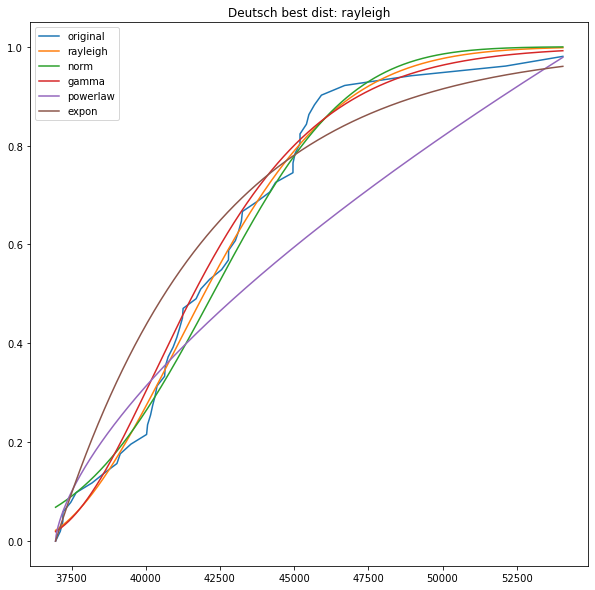

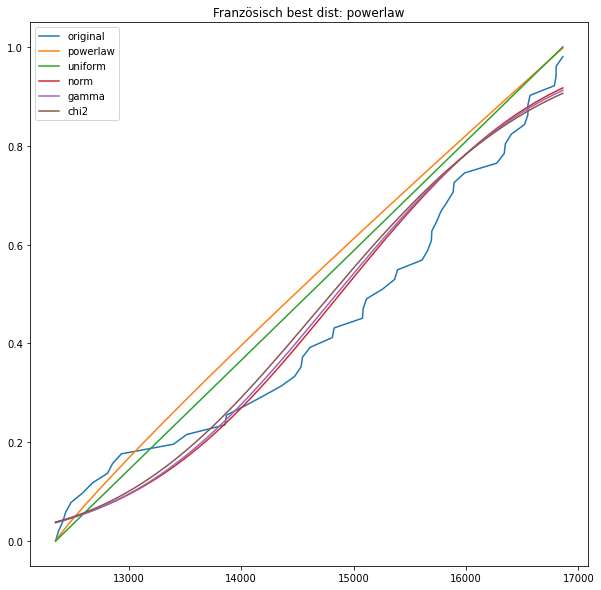

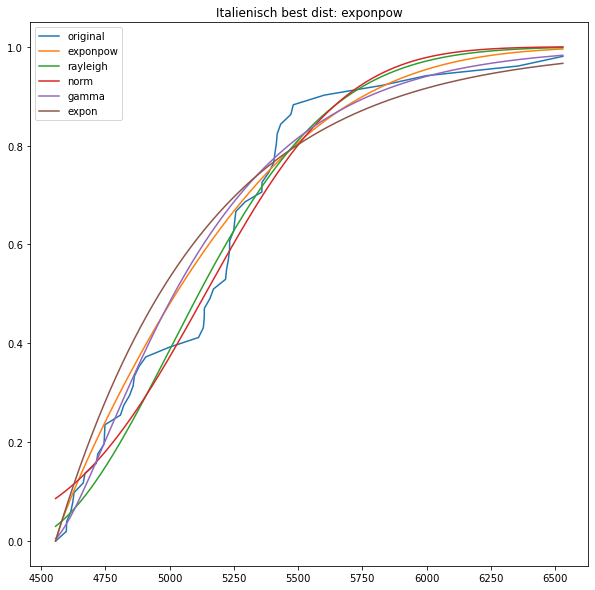

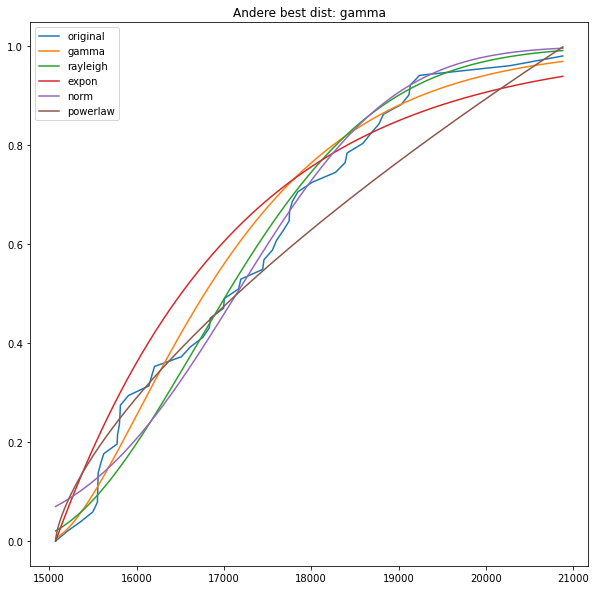

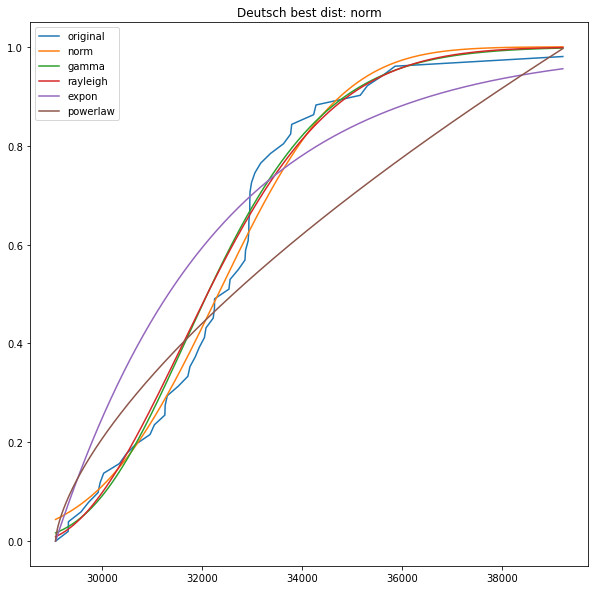

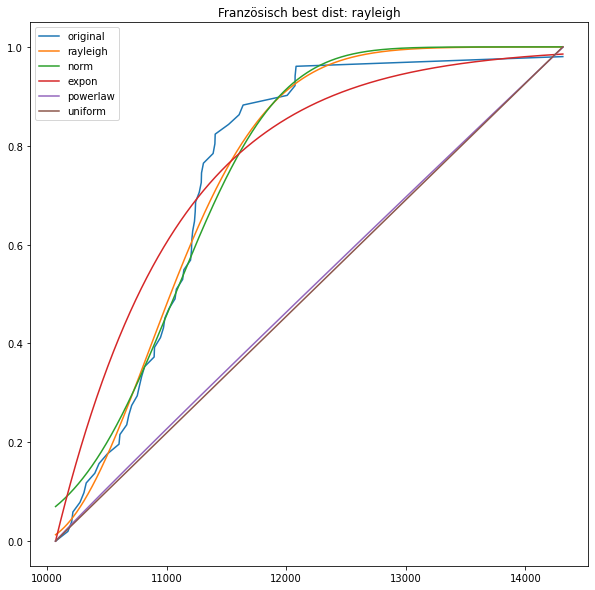

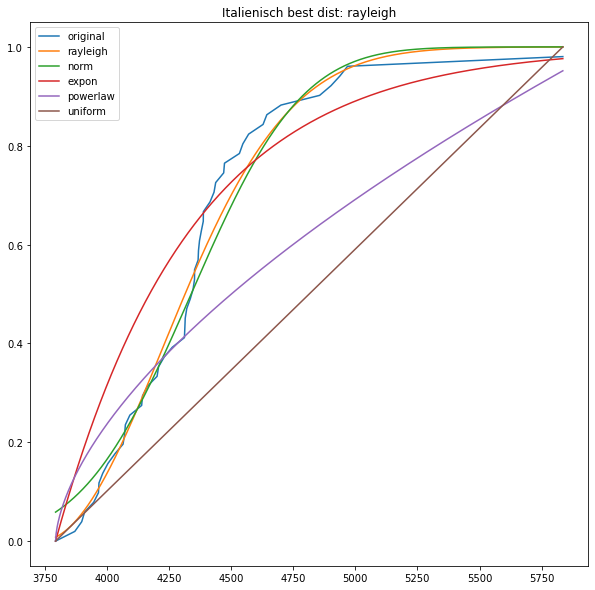

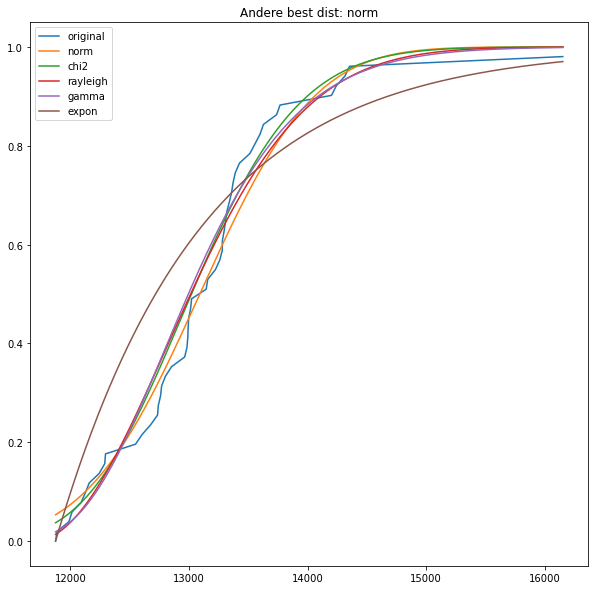

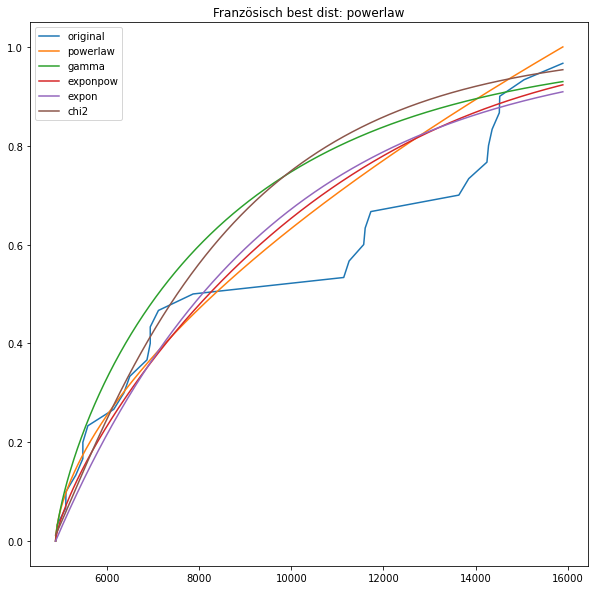

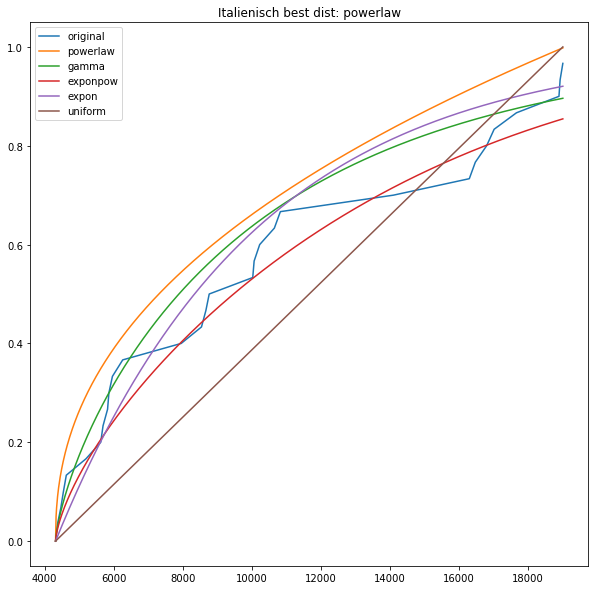

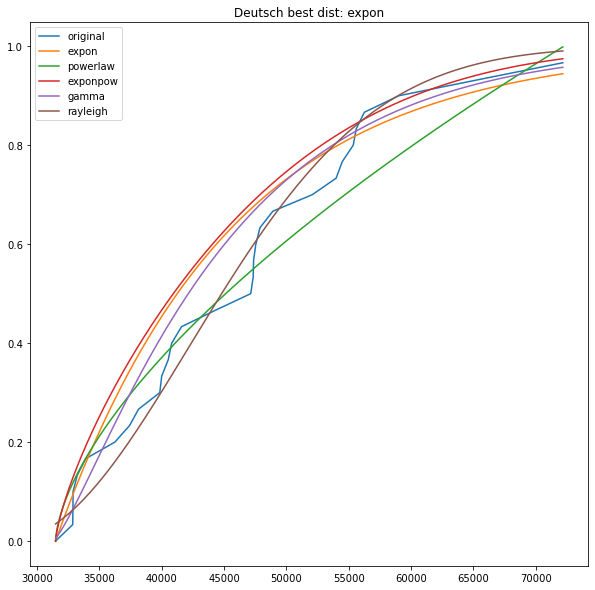

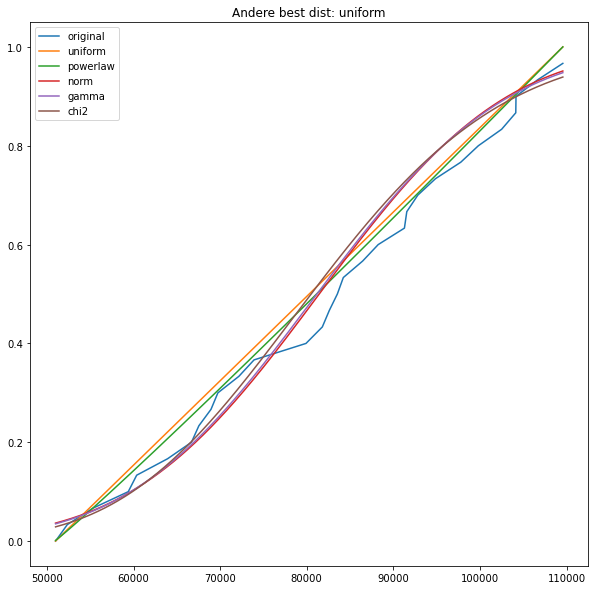

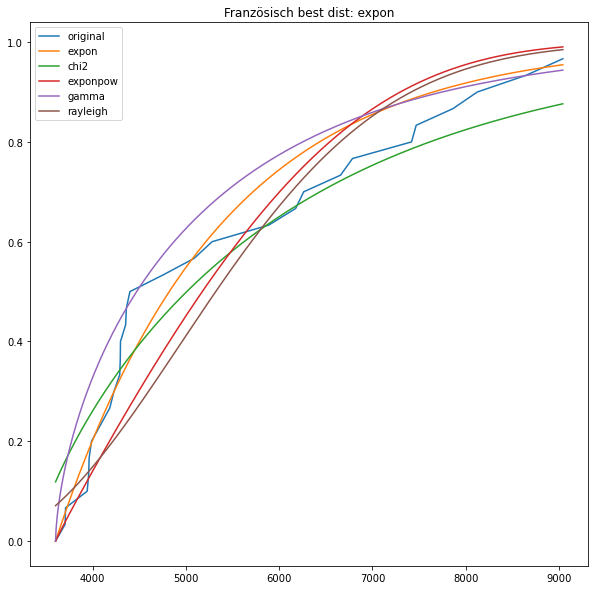

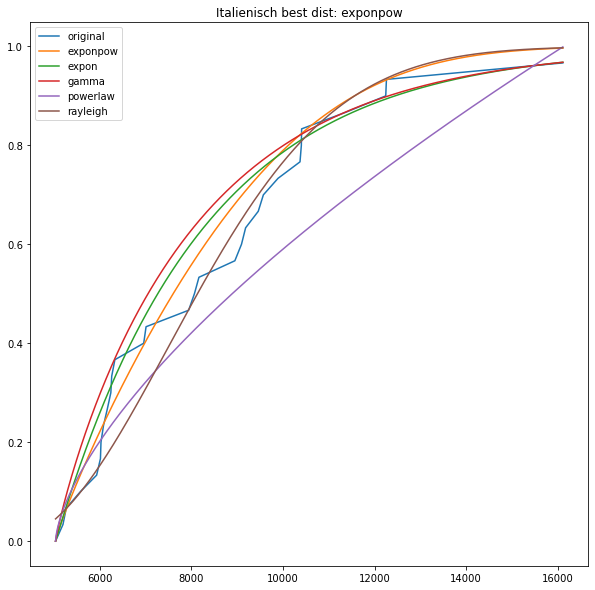

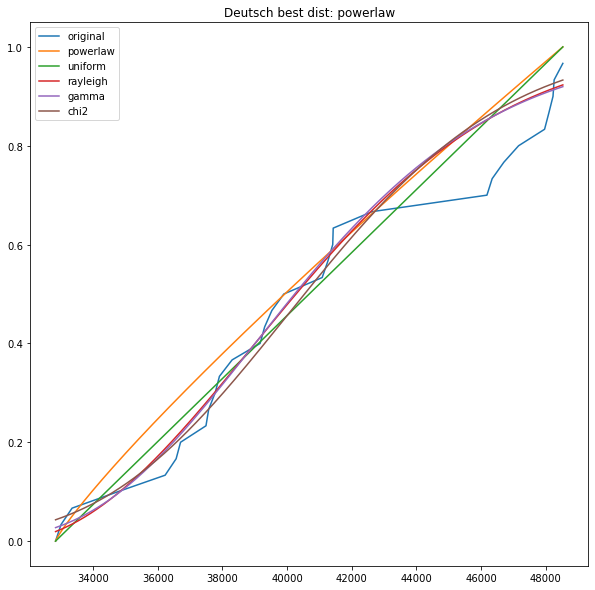

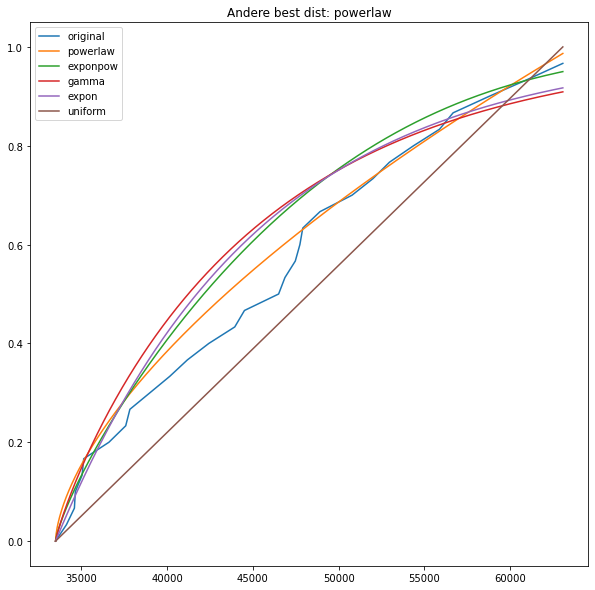

Population start size:  8485665
Population end size:  10981795.490148593


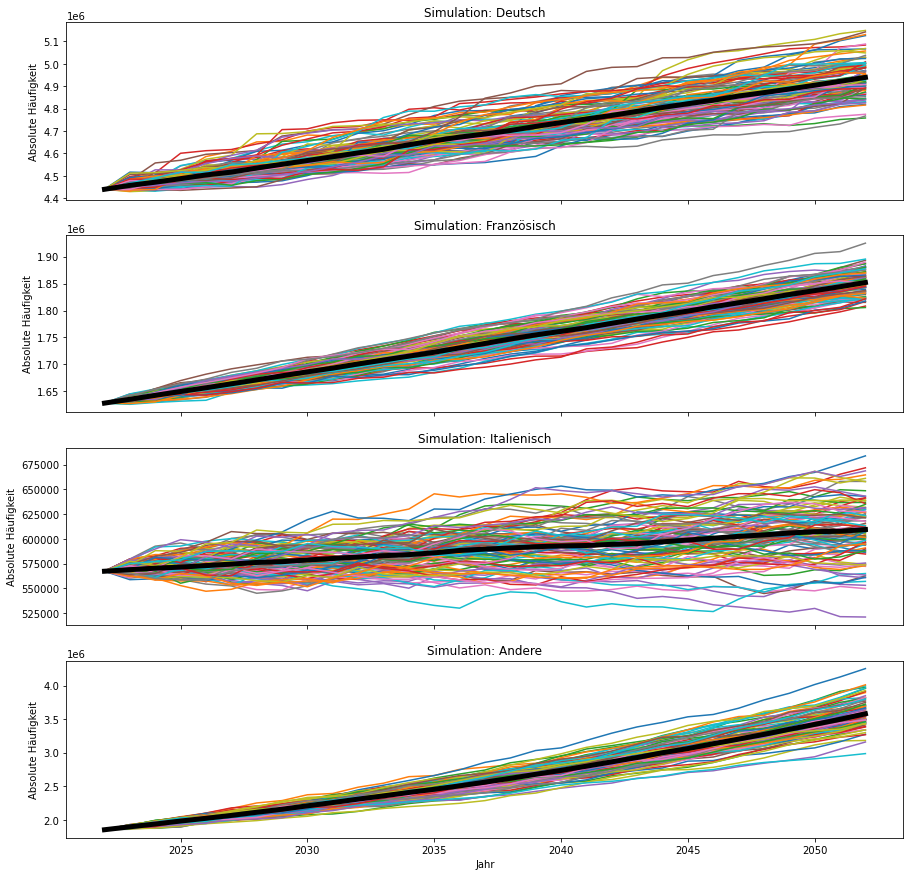

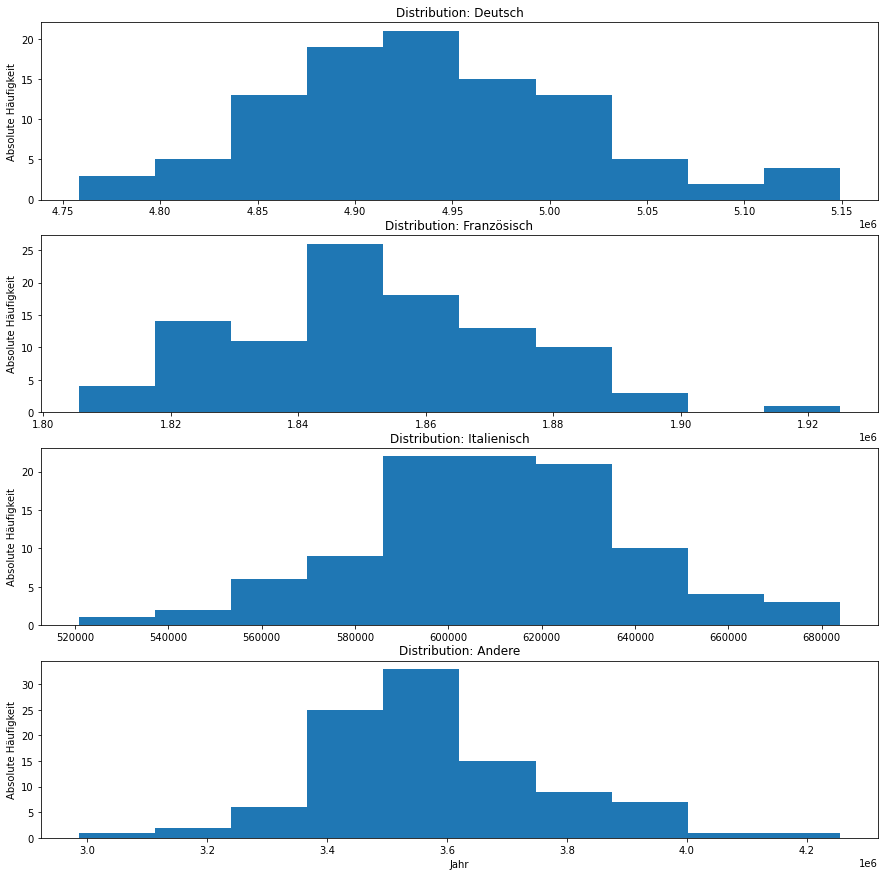

In [37]:
params_geburtenrate = get_distributionParams_of_geburtenrate()
params_todesrate = get_distributionParams_of_todesrate()
params_einwanderung = get_distributionParams_of_einwanderung()
params_auswanderung = get_distributionParams_of_auswanderung()

## erwartungswerte prüfen!!!!!!!!!!

n = 100
years=30
startValues = (4440082, 1628228, 567203, 1850152)

print("Population start size: ", np.sum(startValues))

Deutsch = simulation(params_geburtenrate["Deutsch"], params_todesrate["Deutsch"], params_einwanderung["Deutsch"], params_auswanderung["Deutsch"], startValues[0],years=years,n=n)
Französisch = simulation(params_geburtenrate["Französisch"], params_todesrate["Französisch"], params_einwanderung["Französisch"], params_auswanderung["Französisch"], startValues[1],years=years,n=n)
Italienisch = simulation(params_geburtenrate["Italienisch"], params_todesrate["Italienisch"], params_einwanderung["Italienisch"], params_auswanderung["Italienisch"], startValues[2],years=years,n=n)
Andere = simulation(params_geburtenrate["Andere"], params_todesrate["Andere"], params_einwanderung["Andere"], params_auswanderung["Andere"], startValues[3],years=years,n=n)

print("Population end size: ", np.sum([MeanOfSim(Deutsch)[-1], MeanOfSim(Französisch)[-1], MeanOfSim(Italienisch)[-1], MeanOfSim(Andere)[-1]]))

display_sim(Deutsch, Französisch, Italienisch, Andere, 2022)
display_stackedArea_chart(Deutsch, Französisch, Italienisch, Andere)
display_simulationEnd_dist(Deutsch, Französisch, Italienisch, Andere)